In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ogyeiv2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4250337%2F7413972%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241012%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241012T222240Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5e4ee0d5dcedd0e04f0c47b2039d24fa443e5922470f851d476492fecca610d2d8050ad839cda567da6416f2677c4607fc4183cde135c9ac6caf0de8fb966fc876106c2ed3f2ccb85279591162789b4ddb5a42e21fdd3ae253aeafd14a2ff9774ae7e48d2bda42dddca8385a03dbe7a05fbc4f2e75cbc9e3a1bd67716c36fc726cc11cb50772835218abebf0c5edea7bfaaa047aed80dae2ad13df6cdc35484c5f6e2733592e2be9b3aab03fa0696eb7257f138e4014b2f0ddfda239c0a0da76931db64adef4e8cef0a5d79e7a47963ad0732ffcfbbc677da6e83a28ec644eb951d9ef96b19531fae11e47c5326f32c0ab5ee4b4ea1ea739d39e07933de8b949'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3475414977 bytes downloaded
Downloaded and uncompressed: ogyeiv2
Data source import complete.


## Please comment and upvote if you like this work!

## Take a look at the other notebooks in my profile:
## [CV notebooks](https://www.kaggle.com/killa92/code)

### Datasets and DataLoaders

In [2]:
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

class CustomDataset(Dataset):

    def __init__(self, root, data, transformations = None, im_files = [".jpg", ".png"]):

        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/{data}/images/*{[im_file for im_file in im_files]}"))]
        self.gt_paths = [im_path for im_path in sorted(glob(f"{root}/{data}/labels/*.txt"))]
        self.data, self.cls_counts, self.cls_names, count, data_count = {}, {}, {}, 0, 0
        for idx, (im_path, gt_path) in enumerate(zip(self.im_paths, self.gt_paths)):
            class_name = self.get_class_name(gt_path)
            self.data[im_path] = class_name
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1

    def get_class_name(self, path): return os.path.basename(path).split("_")[0]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):

        im_path = list(self.data.keys())[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[(self.data[im_path])]

        if self.transformations is not None: im = self.transformations(im)

        return im, gt

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):

    tr_ds = CustomDataset(root = root, data = "train", transformations = transformations)
    vl_ds = CustomDataset(root = root, data = "valid", transformations = transformations)
    ts_ds = CustomDataset(root = root, data = "test", transformations = transformations)

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, ts_dl, tr_ds.cls_names

root = "/kaggle/input/ogyeiv2/ogyeiv2/ogyeiv2"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

98
21
672
{'acc': 0, 'advil': 1, 'akineton': 2, 'algoflex': 3, 'algopyrin': 4, 'ambroxol': 5, 'apranax': 6, 'aspirin': 7, 'atoris': 8, 'atorvastatin': 9, 'betaloc': 10, 'bila': 11, 'c': 12, 'calci': 13, 'cataflam': 14, 'cetirizin': 15, 'co': 16, 'cold': 17, 'coldrex': 18, 'concor': 19, 'condrosulf': 20, 'controloc': 21, 'covercard': 22, 'coverex': 23, 'diclopram': 24, 'donalgin': 25, 'dorithricin': 26, 'doxazosin': 27, 'dulodet': 28, 'dulsevia': 29, 'enterol': 30, 'escitil': 31, 'favipiravir': 32, 'frontin': 33, 'furon': 34, 'ibumax': 35, 'indastad': 36, 'jutavit': 37, 'kalcium': 38, 'kalium': 39, 'ketodex': 40, 'koleszterin': 41, 'l': 42, 'lactamed': 43, 'lactiv': 44, 'laresin': 45, 'letrox': 46, 'lordestin': 47, 'magne': 48, 'mebucain': 49, 'merckformin': 50, 'meridian': 51, 'metothyrin': 52, 'mezym': 53, 'milgamma': 54, 'milurit': 55, 'naprosyn': 56, 'narva': 57, 'naturland': 58, 'nebivolol': 59, 'neo': 60, 'no': 61, 'noclaud': 62, 'nolpaza': 63, 'nootropil': 64, 'normodipine': 65, 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Data Visualization

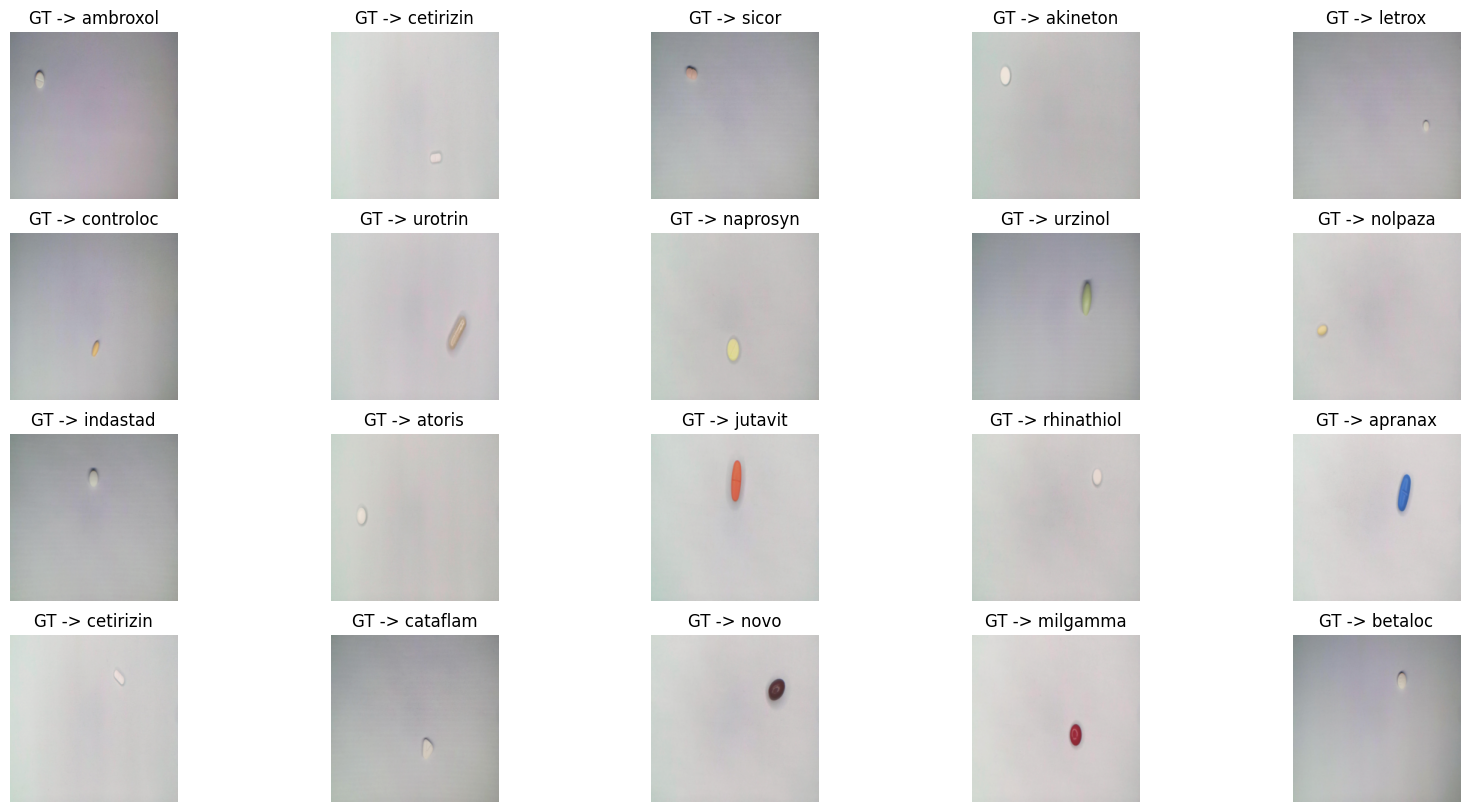

In [3]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")

visualize(data = tr_dl.dataset, n_ims = 20, rows = 4, cmap = "rgb", cls_names = list(classes.keys()))

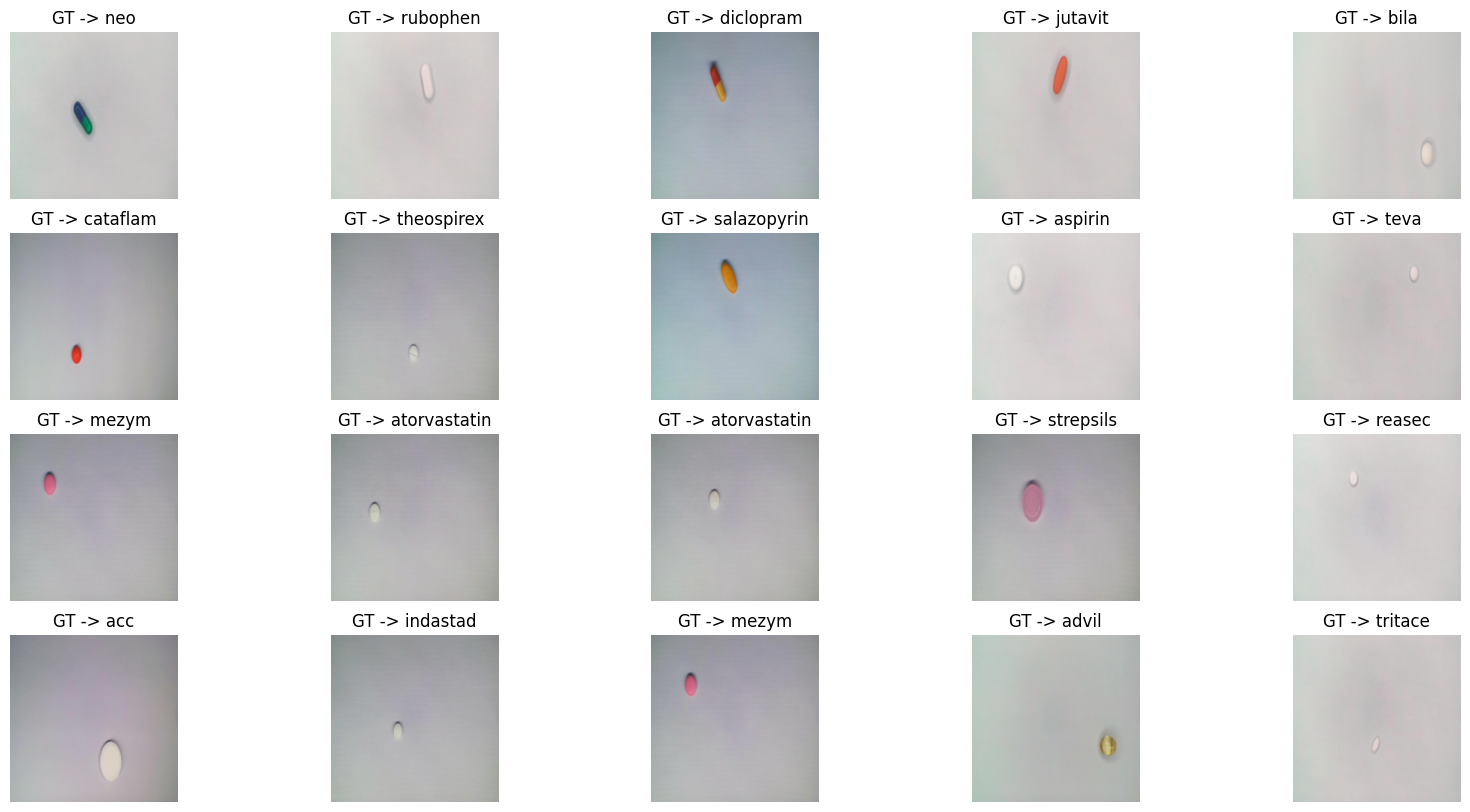

In [4]:
visualize(data = val_dl.dataset, n_ims = 20, rows = 4, cmap = "rgb", cls_names = list(classes.keys()))

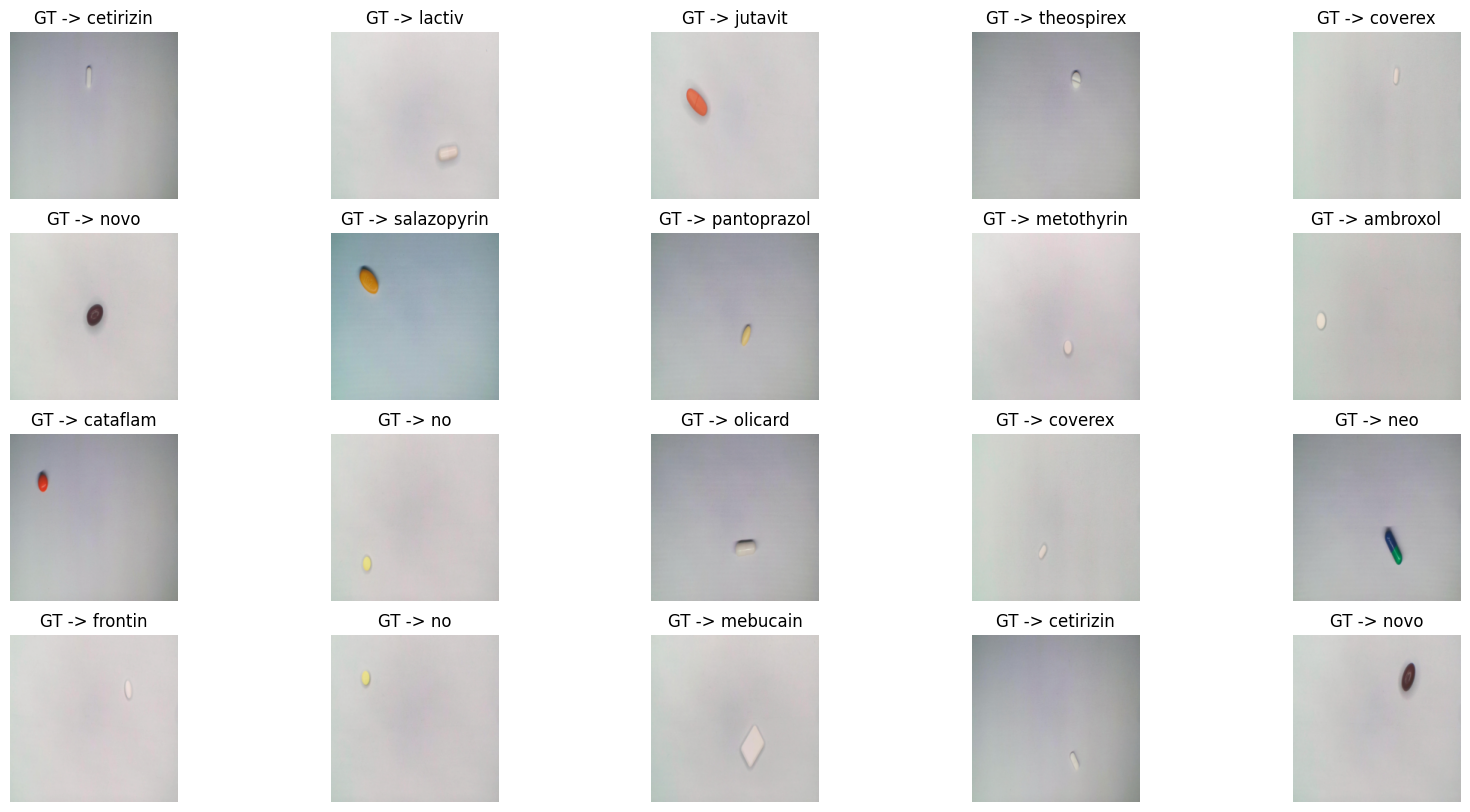

In [5]:
visualize(data = ts_dl.dataset, n_ims = 20, rows = 4, cmap = "rgb", cls_names = list(classes.keys()))

### Data Analysis

<ipython-input-6-554dc3b3b493>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 90)


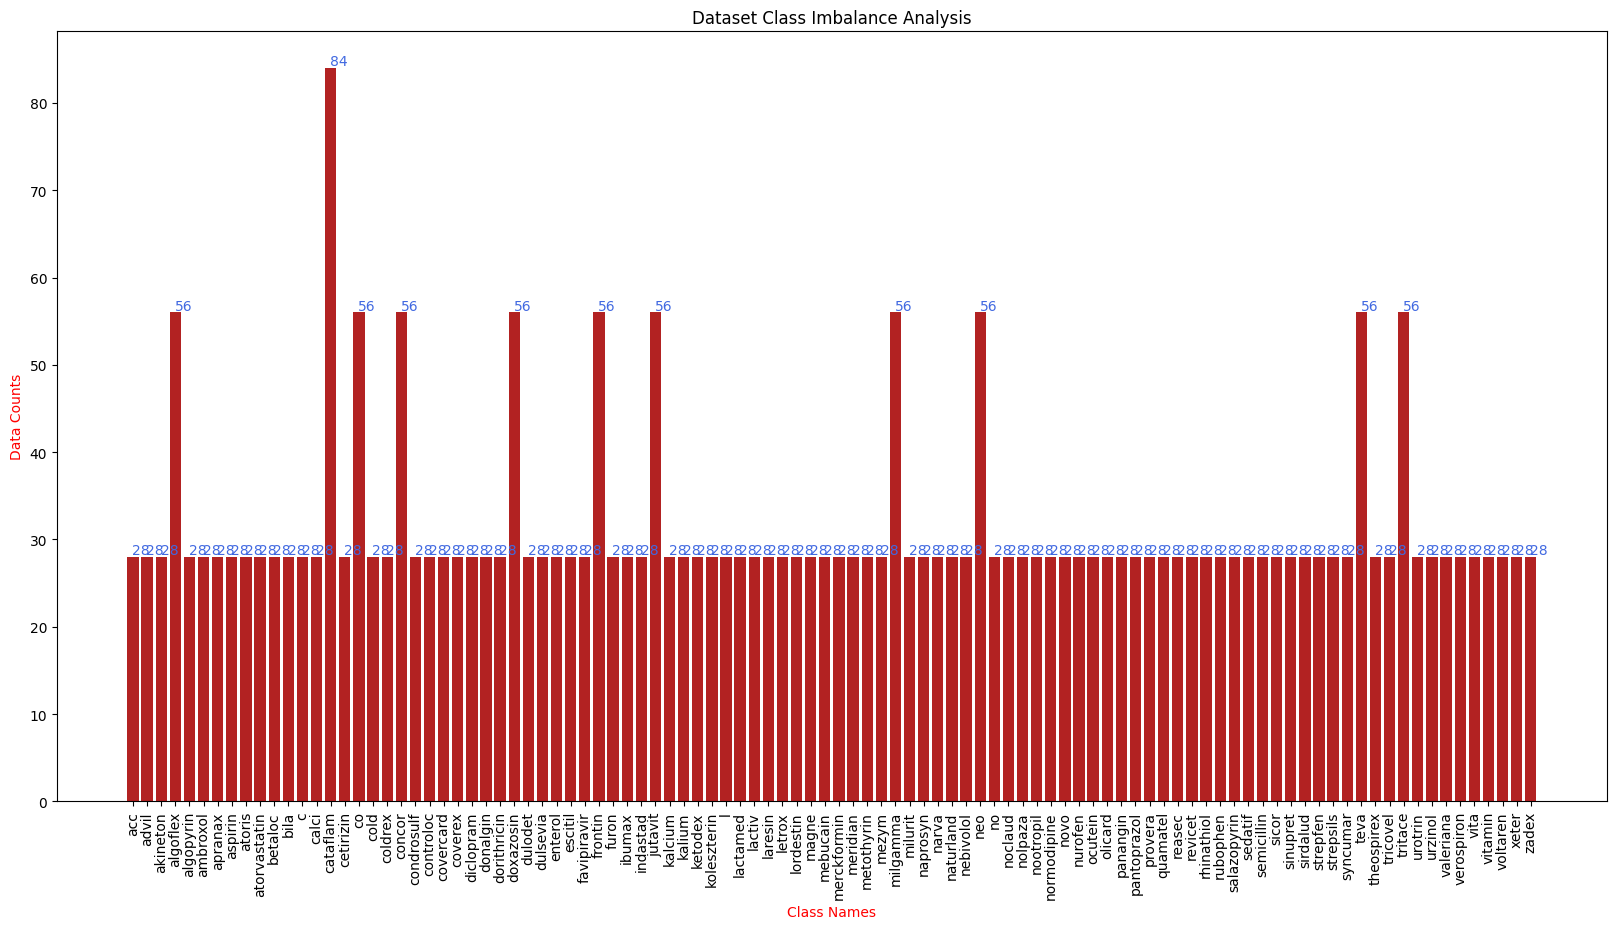

In [6]:
def data_analysis(root, data, transformations):

    ds = CustomDataset(root = root, data = data, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.8, 0.05
    text_height = 0.3
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 90)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")

data_analysis(root = root, data = "train", transformations = tfs)

<ipython-input-6-554dc3b3b493>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 90)


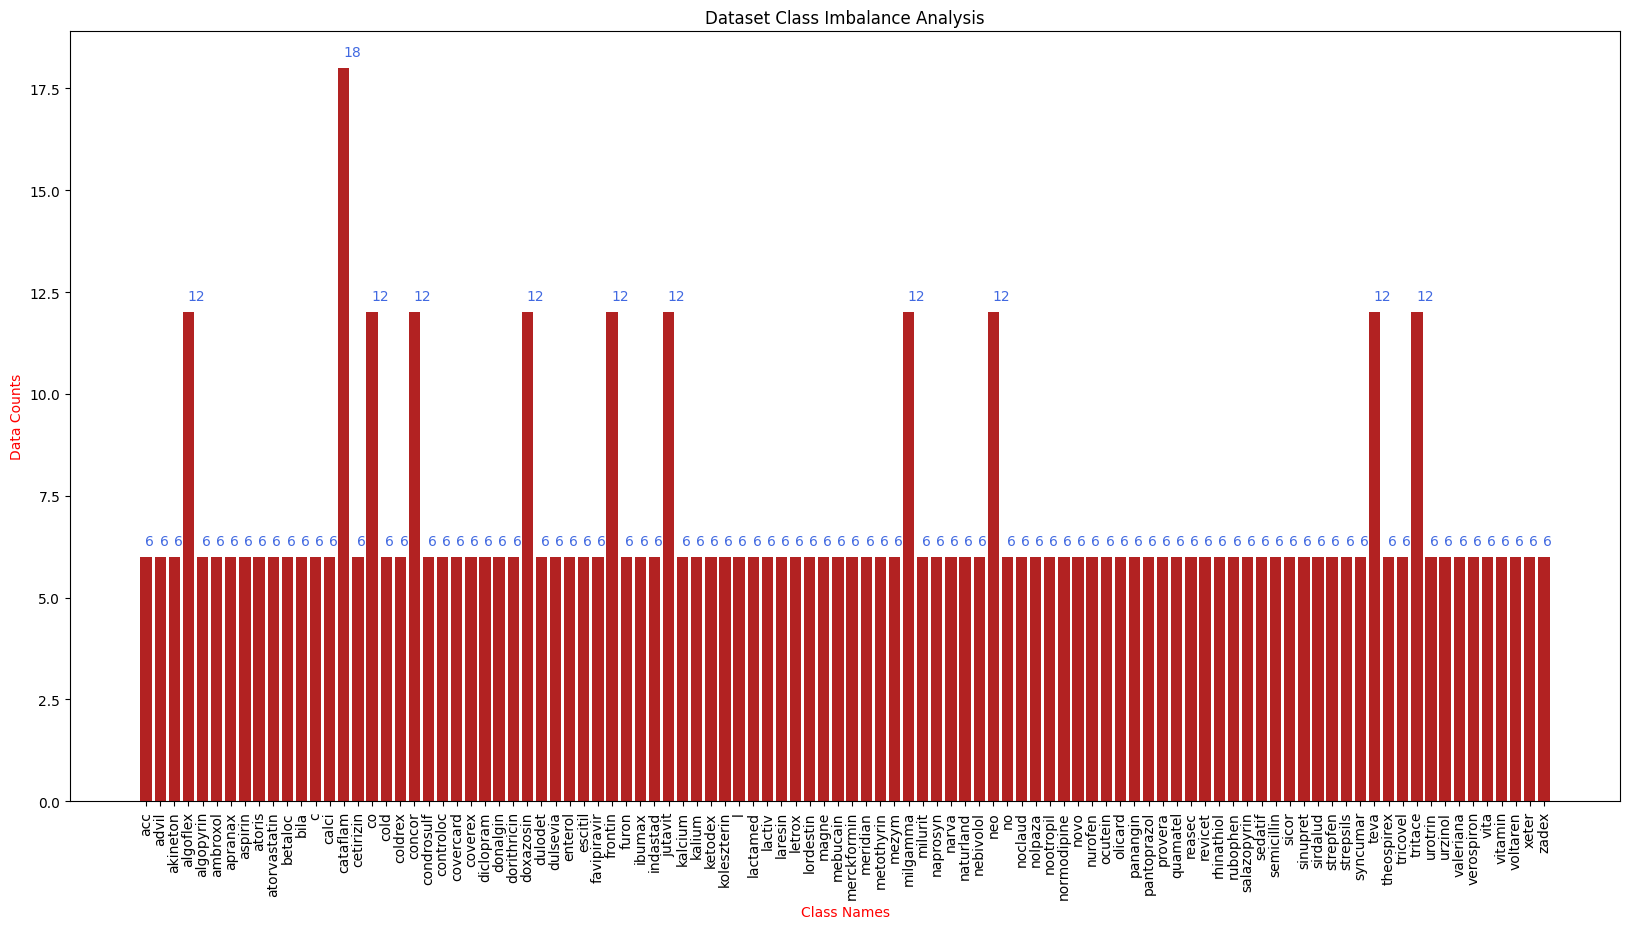

In [7]:
data_analysis(root = root, data = "valid", transformations = tfs)

<ipython-input-6-554dc3b3b493>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 90)


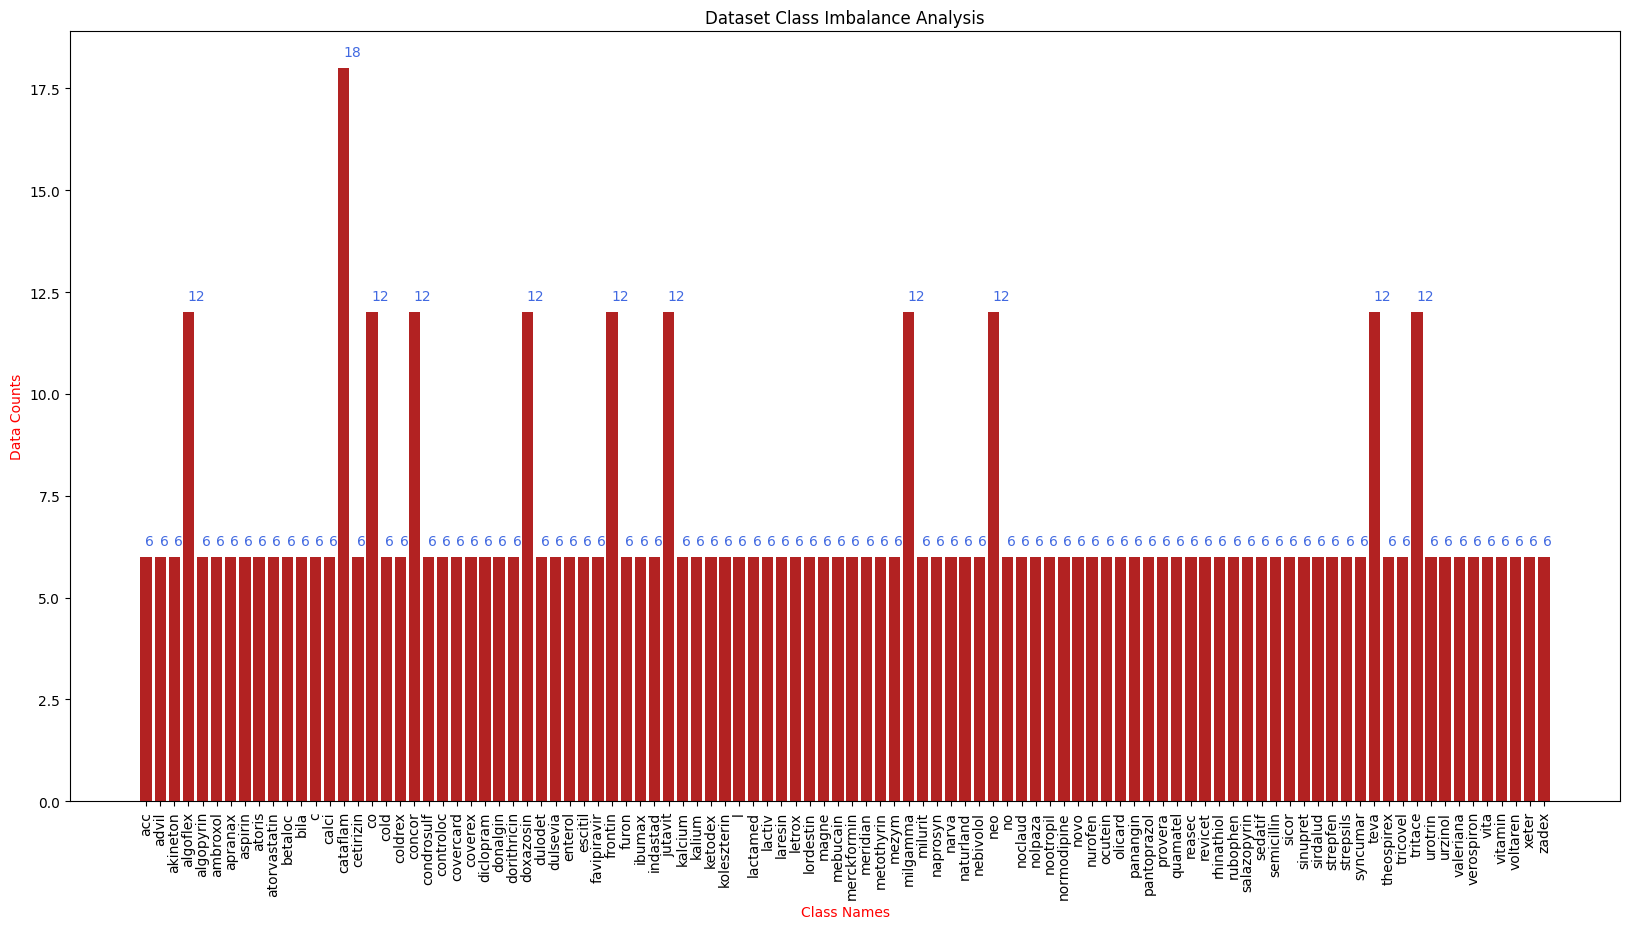

In [8]:
data_analysis(root = root, data = "test", transformations = tfs)

### Train and Validation

In [10]:
!pip install timm
!pip install torchmetrics
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 17.8 MB/s eta 0:00:00


In [11]:
import timm, torchmetrics
from tqdm import tqdm
m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))

def train_setup(m): return m.to("cpu").eval(), 1, "cpu", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "pills", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)

for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc  / len(val_dl.dataset)
        val_f1_to_track   = val_epoch_f1   / len(val_dl)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track); val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Start training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
98it [25:34, 15.66s/it]

1-epoch train process is completed!
1-epoch train loss          -> 3.028
1-epoch train accuracy      -> 0.260
1-epoch train f1-score      -> 0.260


1-epoch validation process is completed!
1-epoch validation loss     -> 1.599
1-epoch validation accuracy -> 0.524
1-epoch validation f1-score -> 0.524


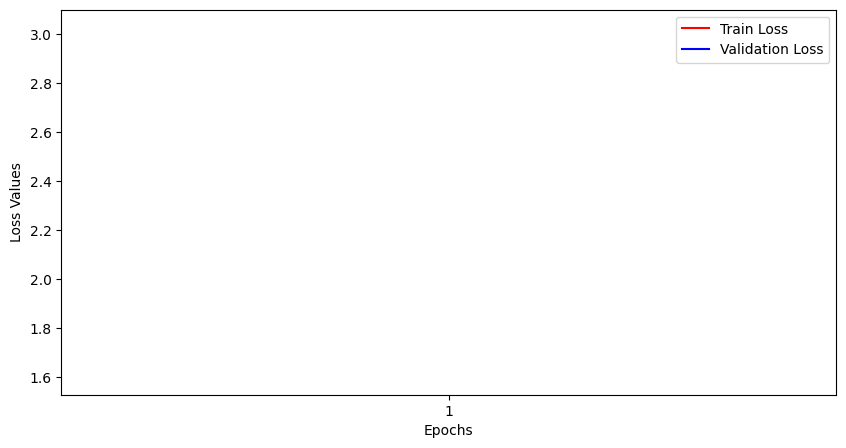

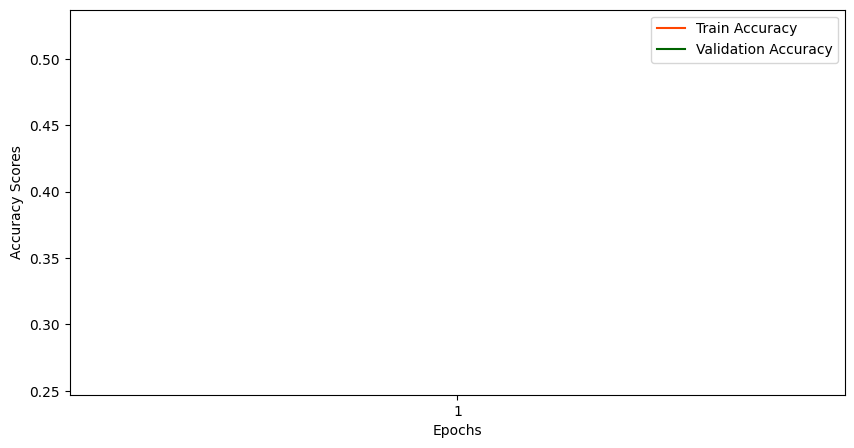

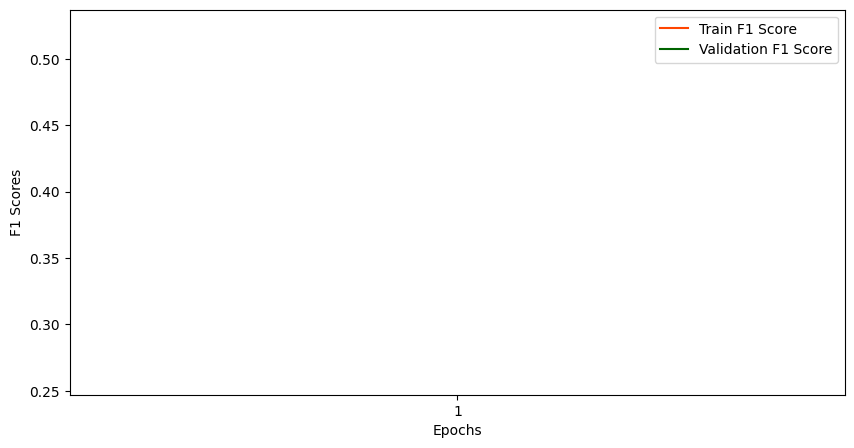

In [12]:
def learning_curves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):

    plt.figure(figsize = (10, 5))
    plt.plot(tr_losses, label = "Train Loss", c = "red")
    plt.plot(val_losses, label = "Validation Loss", c = "blue")
    plt.xlabel("Epochs"); plt.ylabel("Loss Values")
    plt.xticks(ticks = np.arange(len(tr_losses)), labels = [i for i in range(1, len(tr_losses) + 1)])
    plt.legend(); plt.show()

    plt.figure(figsize = (10, 5))
    plt.plot(tr_accs, label = "Train Accuracy", c = "orangered")
    plt.plot(val_accs, label = "Validation Accuracy", c = "darkgreen")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy Scores")
    plt.xticks(ticks = np.arange(len(tr_accs)), labels = [i for i in range(1, len(tr_accs) + 1)])
    plt.legend(); plt.show()

    plt.figure(figsize = (10, 5))
    plt.plot([tr_f1.cpu() for tr_f1 in tr_f1s], label = "Train F1 Score", c = "orangered")
    plt.plot([val_f1.cpu() for val_f1 in val_f1s], label = "Validation F1 Score", c = "darkgreen")
    plt.xlabel("Epochs"); plt.ylabel("F1 Scores")
    plt.xticks(ticks = np.arange(len(tr_f1s)), labels = [i for i in range(1, len(tr_f1s) + 1)])
    plt.legend(); plt.show()

learning_curves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s)

In [14]:
!pip install ai_edge_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.7/100.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 625.5/625.5 MB 764.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.4/120.4 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.19.2
    Uninstalling google-api-core-2.19.2:
      Successfully uninstalled google-api-core-2.19.2
  At

### Inference and Model Performance Analysis

In [ ]:
import cv2
class SaveFeatures():

    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):

    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)

    return (cam - np.min(cam)) / np.max(cam)

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):

    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        im, gt = to_device(batch, device)
        pred_class = torch.argmax(model(im), dim = 1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())

    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]

    for idx, indeks in enumerate(indekslar):

        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)

        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (im_size, im_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet'); plt.axis("off")

        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")

m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(model = m.to(device), device = device, test_dl = ts_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv = final_conv, fc_params = fc_params)


# Quantizing Model

In [15]:
import torch
import torchvision
import ai_edge_torch

from ai_edge_torch.quantize import pt2e_quantizer
from ai_edge_torch.quantize import quant_config
from torch.ao.quantization import quantize_pt2e

sample_inputs = (torch.randn(1, 3, 224, 224),)

quantizer = pt2e_quantizer.PT2EQuantizer().set_global(
    pt2e_quantizer.get_symmetric_quantization_config()
)
model = torch._export.capture_pre_autograd_graph(m, sample_inputs)
model = quantize_pt2e.prepare_pt2e(model, quantizer)

# import cv2
# import numpy
# img = cv2.imread("clock.jpg")
# img = cv2.resize(img, (224, 224))
# img = numpy.expand_dims(img, 0)
# img = numpy.transpose(img, (0, 3, 1, 2))
# img = img / 255.0
# img = img.astype(numpy.float32)
# model(torch.from_numpy(img)) # calibration

model = quantize_pt2e.convert_pt2e(model, fold_quantize=False)

with_quantizer = ai_edge_torch.convert(
    model,
    sample_inputs,
    quant_config=quant_config.QuantConfig(pt2e_quantizer=quantizer),
)
with_quantizer.export("mobilenet_quant.tflite")

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
W1013 09:23:37.689000 132355910901760 torch/_export/__init__.py:95] +============================+
W1013 09:23:37.693000 132355910901760 torch/_export/__init__.py:96] |     !!!   WARNING   !!!    |
W1013 09:23:37.698000 132355910901760 torch/_export/__init__.py:97] +============================+
W1013 09:23:37.701000 132355910901760 torch/_export/__init__.py:98] capture_pre_autograd_graph() is deprecated and doesn't provide any function guarantee moving forward.
W1013 09:23:37.703000 132355910901760 torch/_export/__init__.py:99] Please switch to use torch.export instead.
/usr/local/lib/python3.10/dist-packages/tor

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
